In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd
import geopandas as gpd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap

In [2]:
alliance = ['BNP', 'Jamaat-NCP']

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/muhallilahnaf/election-2026-live/master/data/seat_votes_pa.csv')
df.head()

,seat_no,name,vote,party,alliance,seat,district,division,region,voters,male_voters,female_voters,thirdgender_voters,time,vote_pc
0,95,কপিল কৃষ্ণ মন্ডল,114323,BNP,BNP,Bagerhat-1,Bagerhat,Khulna,Rural,375560.0,190838.0,184720.0,2.0,2026-02-14 06:07:03.699877+00:00,30.44
1,95,মোঃ মশিউর রহমান খান,117527,Jamaat,Jamaat-NCP,Bagerhat-1,Bagerhat,Khulna,Rural,375560.0,190838.0,184720.0,2.0,2026-02-14 06:07:03.699877+00:00,31.29
2,96,শেখ মোহাম্মদ জাকির হোসেন,66409,BNP,BNP,Bagerhat-2,Bagerhat,Khulna,Urban,338009.0,167739.0,170265.0,5.0,2026-02-14 06:07:03.699877+00:00,19.65
3,96,শেখ মনজুরুল হক (রাহাদ),117709,Jamaat,Jamaat-NCP,Bagerhat-2,Bagerhat,Khulna,Urban,338009.0,167739.0,170265.0,5.0,2026-02-14 06:07:03.699877+00:00,34.82
4,97,শেখ ফরিদুল ইসলাম,103711,BNP,BNP,Bagerhat-3,Bagerhat,Khulna,Rural,266864.0,132350.0,134510.0,4.0,2026-02-14 06:07:03.699877+00:00,38.86


In [6]:
# find seats where either BNP or Jamaat-NCP alliance is missing from contest
seat_alliance_missing = []
def find_seat_missing_alliance(x):
    row = df[(df.seat==x) & (df.alliance=='BNP')].shape[0]
    if row == 0:
        seat_alliance_missing.append(x)
        return
    row = df[(df.seat==x) & (df.alliance=='Jamaat-NCP')].shape[0]
    if row == 0:
        seat_alliance_missing.append(x)
        return
df.seat.apply(find_seat_missing_alliance)
seat_alliance_missing = list(set(seat_alliance_missing))
print(seat_alliance_missing)

['Comilla-7', 'Barguna-1', 'Satkhira-3', 'Patuakhali-4', 'Jessore-5', 'Sunamganj-3', 'Patuakhali-3', 'Chittagong-13', 'Munshiganj-3', 'Tangail-3', 'Gopalganj-1', 'Chandpur-4', 'Comilla-2', 'Jhenaidah-4', 'Kurigram-3', 'Mymensingh-6', 'Netrokona-3', 'Gopalganj-2', 'Mymensingh-3', 'Brahmanbaria-2', 'Narsingdi-3', 'Chittagong-12', 'Kishoreganj-5', 'Brahmanbaria-5', 'Narail-2', 'Barisal-5', 'Chittagong-6', 'Tangail-8', 'Gopalganj-3', 'Brahmanbaria-1', 'Manikganj-1', 'Habiganj-4', 'Mymensingh-10', 'Natore-3', 'Rangamati', 'Tangail-4', 'Mymensingh-11', 'Dinajpur-5', 'Mymensingh-1', 'Khagrachari', 'Madaripur-2']


In [7]:
dfa = df[~df.seat.isin(seat_alliance_missing)]
dfa.shape

(512, 15)

In [8]:
# calculate vote gap between BNP and Jamaat-NCP alliance
vote_gap = {}
for seat in dfa.seat.unique().tolist():
    vote_bnp = dfa[(dfa.seat==seat) & (dfa.alliance=='BNP')]['vote'].iloc[0]
    vote_jncp = dfa[(dfa.seat==seat) & (dfa.alliance=='Jamaat-NCP')]['vote'].iloc[0]
    vote_gap[seat] = vote_bnp-vote_jncp
    
# sort gap data
sorted_gap = sorted(vote_gap.items(), key=lambda x: x[1])
sorted_gap = dict(sorted_gap)

# convert gap data to df for merging
ordered_seat = pd.DataFrame.from_dict(sorted_gap, orient='index').reset_index()
ordered_seat.columns = ['seat', 'vote_gap']

# merge gap data with main df
dfa_ordered = pd.merge(ordered_seat, dfa, how='inner', on='seat')
dfa_ordered.head()

,seat,vote_gap,seat_no,name,vote,party,alliance,district,division,region,voters,male_voters,female_voters,thirdgender_voters,time,vote_pc
0,Satkhira-2,-150730,106,মোঃ আব্দুর রউফ,116229,BNP,BNP,Satkhira,Khulna,Urban,535654.0,265965.0,269685.0,4.0,2026-02-14 06:07:03.699877+00:00,21.70
1,Satkhira-2,-150730,106,মুহাম্মাদ আব্দুল খালেক,266959,Jamaat,Jamaat-NCP,Satkhira,Khulna,Urban,535654.0,265965.0,269685.0,4.0,2026-02-14 06:07:03.699877+00:00,49.84
2,Comilla-4,-116698,252,মোঃ আঃ জসিম উদ্দিন,49885,GOP (Nuru),BNP,Comilla,Chittagong,Rural,410559.0,215237.0,195319.0,3.0,2026-02-14 06:07:03.699877+00:00,12.15
3,Comilla-4,-116698,252,মোঃ আবুল হাসনাত,166583,NCP,Jamaat-NCP,Comilla,Chittagong,Rural,410559.0,215237.0,195319.0,3.0,2026-02-14 06:07:03.699877+00:00,40.57
4,Gaibandha-1,-102729,29,খন্দকার জিয়াউল ইসলাম মোহাম্মদ আলী,37997,BNP,BNP,Gaibandha,Rangpur,Rural,419111.0,207573.0,211535.0,3.0,2026-02-14 06:07:03.699877+00:00,9.07


C:\Users\matus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\matus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\matus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\matus\AppData\Local\Programs\Python\Python310\lib\site-p

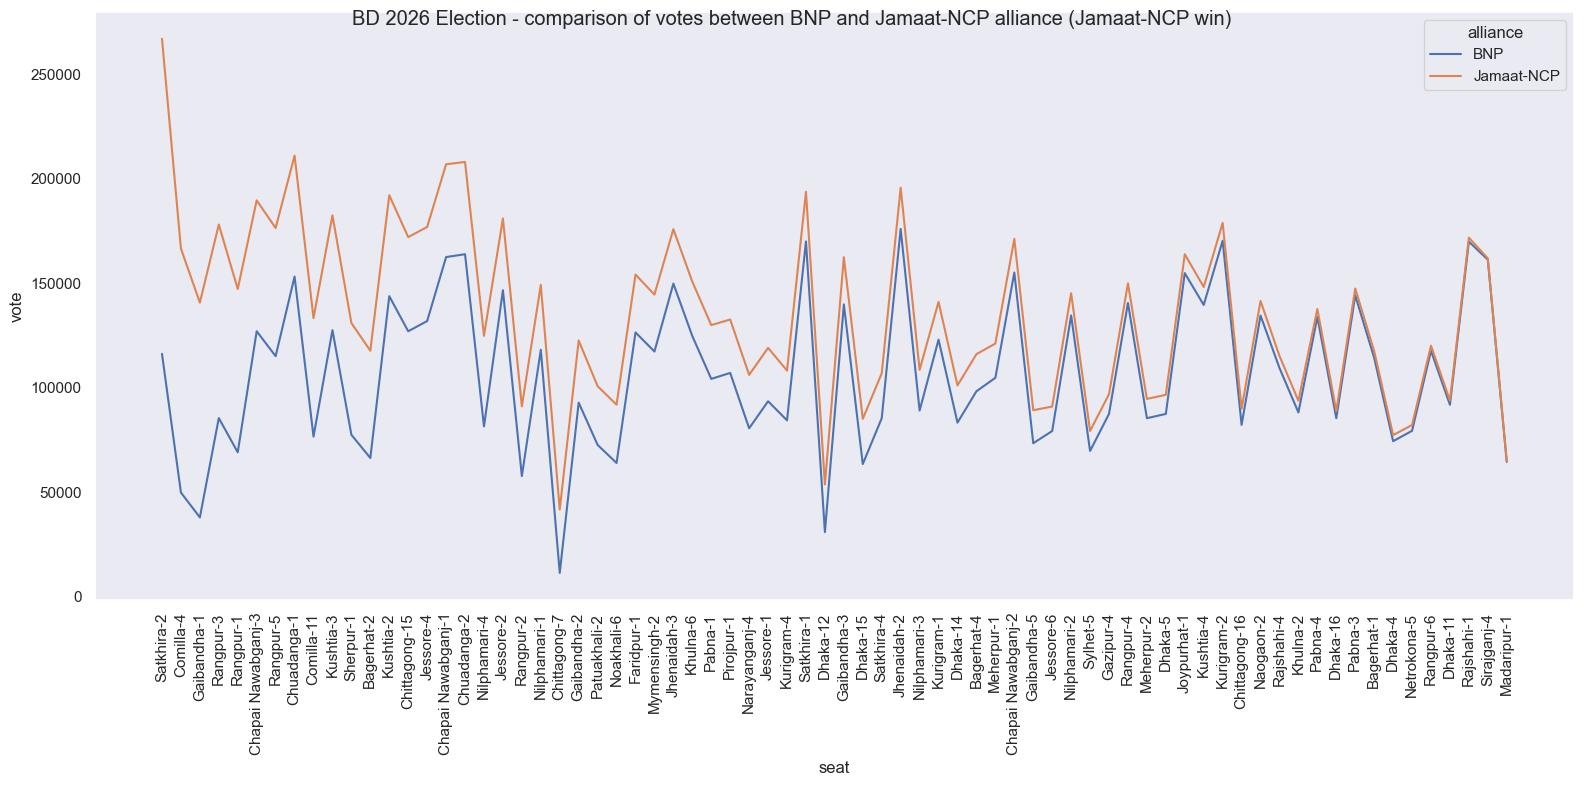

In [57]:
# plot alliance vote gap where Jamaat-NCP got more votes
dfa_ordered_neg = dfa_ordered[dfa_ordered.vote_gap < 0]
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x='seat', y='vote', hue='alliance', data=dfa_ordered_neg, ax=ax)
ax.tick_params(axis='x', labelrotation=90)
ax.grid(False)
fig.tight_layout()
plt.suptitle('BD 2026 Election - comparison of votes between BNP and Jamaat-NCP alliance (Jamaat-NCP win)')
fig.savefig('fig/election_2026_alliance_jamaat_ncp_win_vote_gap',bbox_inches='tight')
plt.show()

C:\Users\matus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\matus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\matus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\matus\AppData\Local\Programs\Python\Python310\lib\site-p

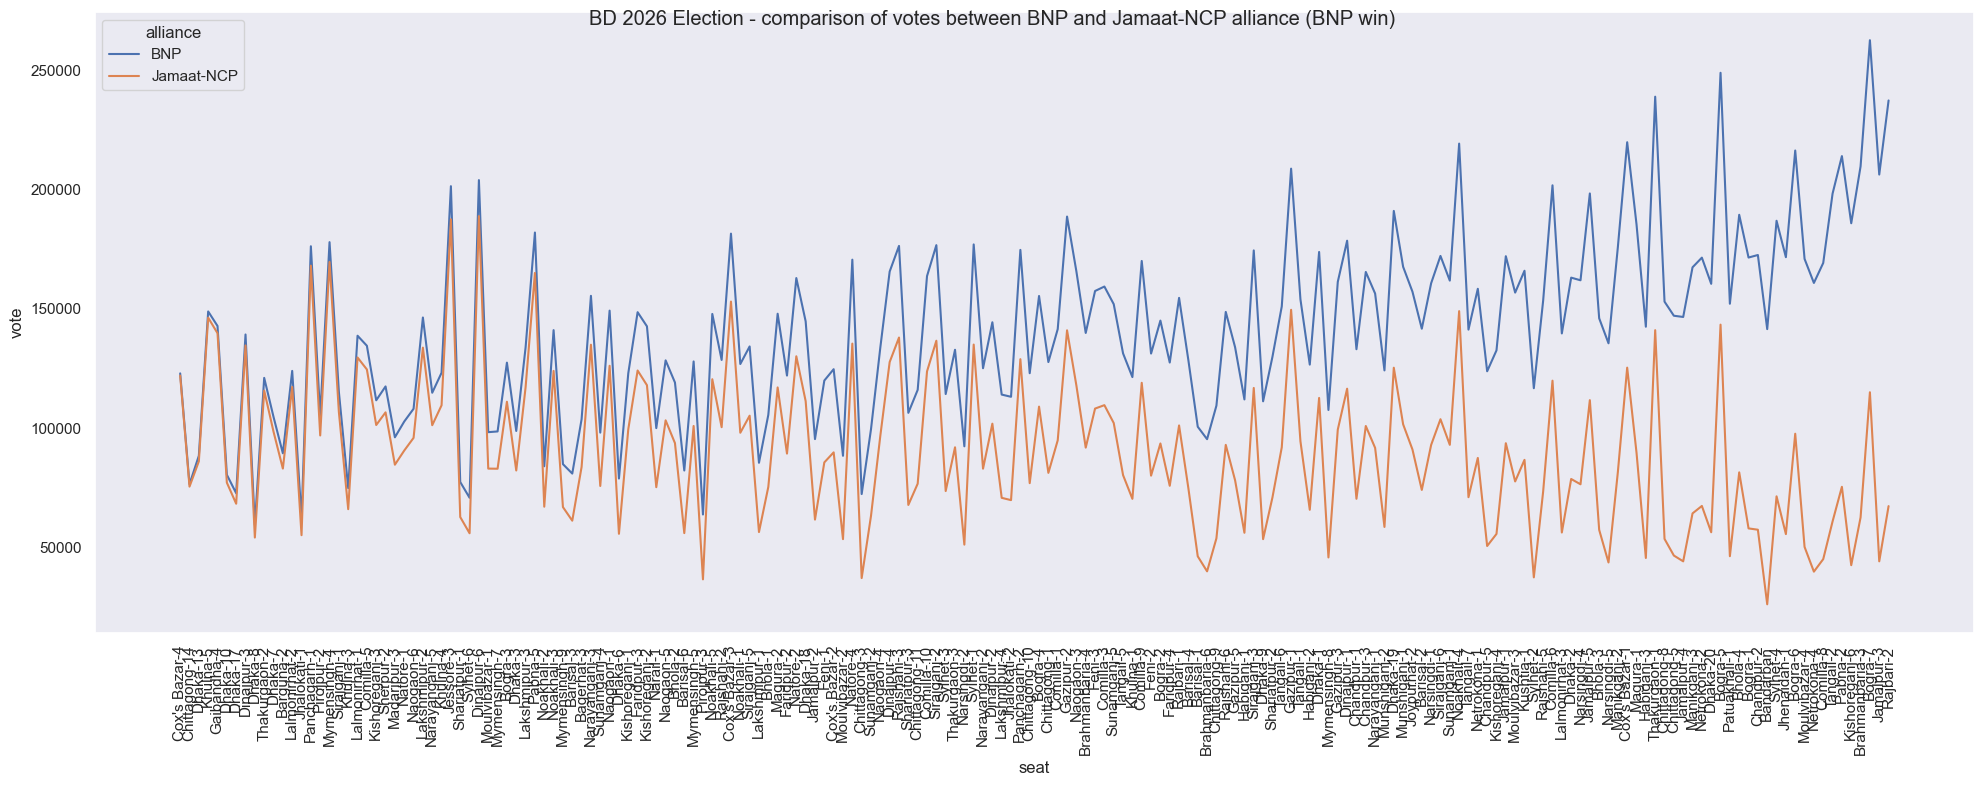

In [58]:
# plot alliance vote gap where BNP got more votes
dfa_ordered_pos = dfa_ordered[dfa_ordered.vote_gap >= 0]
fig, ax = plt.subplots(figsize=(20, 8))
sns.lineplot(x='seat', y='vote', hue='alliance', data=dfa_ordered_pos, ax=ax)
ax.tick_params(axis='x', labelrotation=90)
ax.grid(False)
fig.tight_layout()
plt.suptitle('BD 2026 Election - comparison of votes between BNP and Jamaat-NCP alliance (BNP win)')
fig.savefig('fig/election_2026_alliance_bnp_win_vote_gap',bbox_inches='tight')
plt.show()

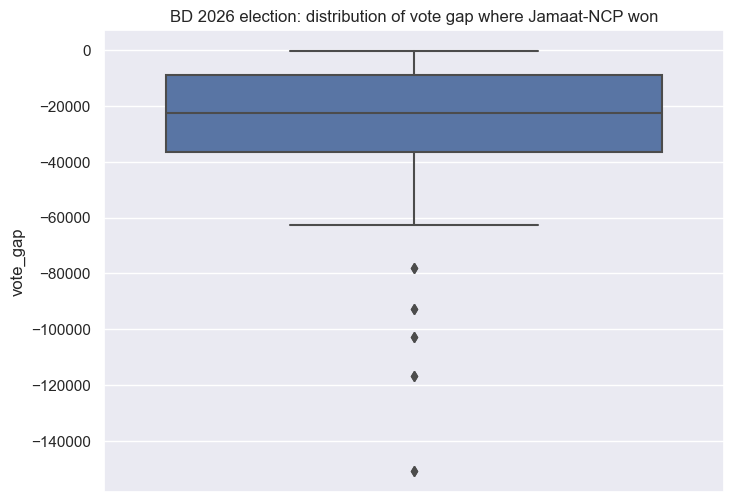

In [59]:
# plot distribution of vote gap where Jamaat-NCP won
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=dfa_ordered_neg, y="vote_gap", ax=ax)
ax.set_title('BD 2026 election: distribution of vote gap where Jamaat-NCP won')
fig.savefig('fig/election_2026_alliance_jamaat_ncp_win_vote_gap_distn',bbox_inches='tight')

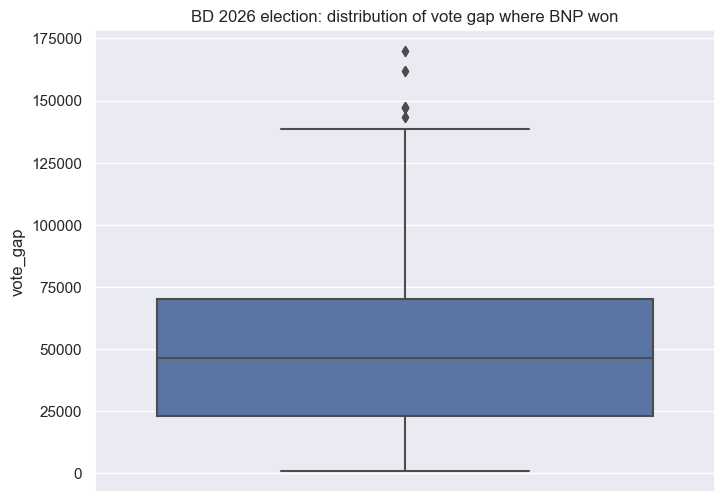

In [60]:
# plot distribution of vote gap where BNP won
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=dfa_ordered_pos, y="vote_gap", ax=ax)
ax.set_title('BD 2026 election: distribution of vote gap where BNP won')
fig.savefig('fig/election_2026_alliance_bnp_win_vote_gap_distn',bbox_inches='tight')

In [9]:
bdmap = gpd.read_file('map/seats.shp')
bdmap.head()

,seat_no,seat,district,division,region,shape_len,shape_area,geometry
0,1,Panchagarh-1,Panchagarh,Rangpur,Urban,2.787812,0.061199,"POLYGON ((88.72746 26.34527, 88.72772 26.34494..."
1,2,Panchagarh-2,Panchagarh,Rangpur,Rural,1.411258,0.064286,"POLYGON ((88.76158 26.30059, 88.76176 26.29971..."
2,3,Thakurgaon-1,Thakurgaon,Rangpur,Urban,1.255212,0.058832,"POLYGON ((88.55589 26.17948, 88.55684 26.17788..."
3,4,Thakurgaon-2,Thakurgaon,Rangpur,Rural,1.858839,0.045806,"POLYGON ((88.32191 26.20205, 88.3222 26.20129,..."
4,5,Thakurgaon-3,Thakurgaon,Rangpur,Rural,1.810654,0.059069,"POLYGON ((88.25475 26.03583, 88.25828 26.03391..."


In [10]:
# join data with map data
map_dfa = pd.merge(bdmap, dfa_ordered, how='left', on='seat')
map_dfa.head()

,seat_no_x,seat,district_x,division_x,region_x,shape_len,shape_area,geometry,vote_gap,seat_no_y,...,alliance,district_y,division_y,region_y,voters,male_voters,female_voters,thirdgender_voters,time,vote_pc
0,1,Panchagarh-1,Panchagarh,Rangpur,Urban,2.787812,0.061199,"POLYGON ((88.72746 26.34527, 88.72772 26.34494...",8120.0,1.0,...,BNP,Panchagarh,Rangpur,Urban,463700.0,231976.0,231723.0,1.0,2026-02-14 06:07:03.699877+00:00,37.99
1,1,Panchagarh-1,Panchagarh,Rangpur,Urban,2.787812,0.061199,"POLYGON ((88.72746 26.34527, 88.72772 26.34494...",8120.0,1.0,...,Jamaat-NCP,Panchagarh,Rangpur,Urban,463700.0,231976.0,231723.0,1.0,2026-02-14 06:07:03.699877+00:00,36.24
2,2,Panchagarh-2,Panchagarh,Rangpur,Rural,1.411258,0.064286,"POLYGON ((88.76158 26.30059, 88.76176 26.29971...",45788.0,2.0,...,BNP,Panchagarh,Rangpur,Rural,417529.0,209708.0,207818.0,3.0,2026-02-14 06:07:03.699877+00:00,41.83
3,2,Panchagarh-2,Panchagarh,Rangpur,Rural,1.411258,0.064286,"POLYGON ((88.76158 26.30059, 88.76176 26.29971...",45788.0,2.0,...,Jamaat-NCP,Panchagarh,Rangpur,Rural,417529.0,209708.0,207818.0,3.0,2026-02-14 06:07:03.699877+00:00,30.86
4,3,Thakurgaon-1,Thakurgaon,Rangpur,Urban,1.255212,0.058832,"POLYGON ((88.55589 26.17948, 88.55684 26.17788...",97819.0,3.0,...,BNP,Thakurgaon,Rangpur,Urban,511629.0,255053.0,256572.0,4.0,2026-02-14 06:07:03.699877+00:00,46.68


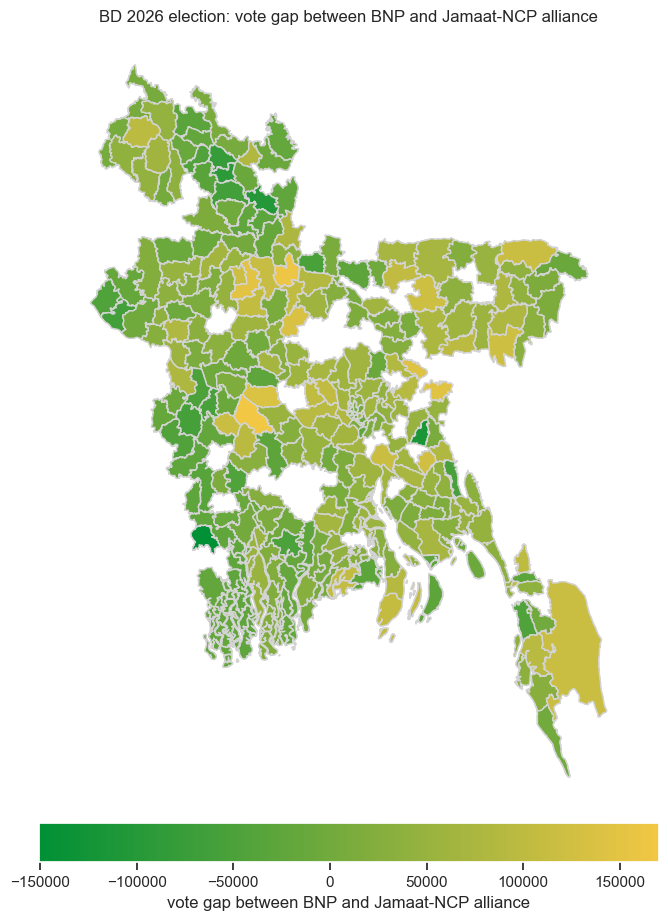

In [11]:
# plot map
fig, ax = plt.subplots(figsize=(8, 14))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

cmap = LinearSegmentedColormap.from_list(
    'mycmap', [(0, '#009036'), (1, '#F2C744')])

map_dfa.plot(
    column='vote_gap', 
    cmap=cmap, 
    edgecolor='lightgrey',
    legend=True, 
    ax=ax,
    cax=cax,
    legend_kwds={
        'label': 'vote gap between BNP and Jamaat-NCP alliance',
        'orientation': 'horizontal'
    }
)
ax.set_axis_off()
ax.title.set_text("BD 2026 election: vote gap between BNP and Jamaat-NCP alliance")
fig.savefig('fig/election_2026_map_alliance_vote_gap',bbox_inches='tight')

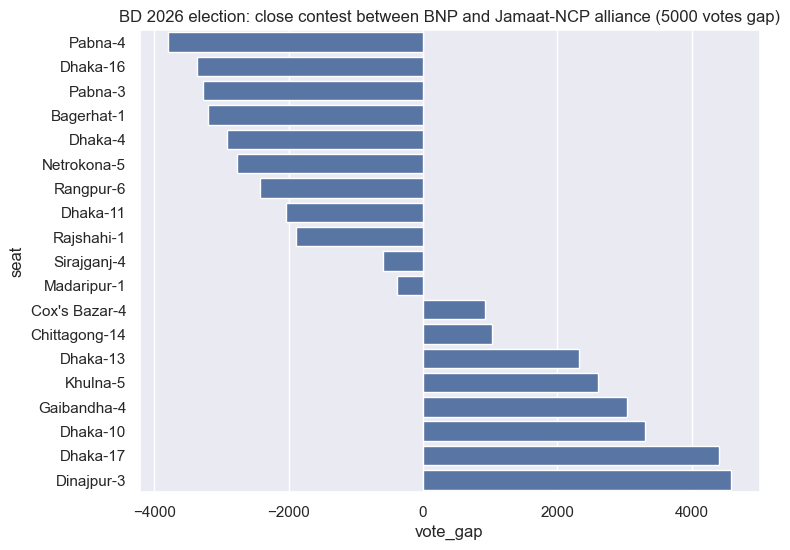

In [12]:
# plot close contests
dfa_cc = dfa_ordered[(dfa_ordered.vote_gap>-5000) & (dfa_ordered.vote_gap<5000)]
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=dfa_cc, x='vote_gap', y='seat', orient='horizontal', ax=ax)
ax.set_title('BD 2026 election: close contest between BNP and Jamaat-NCP alliance (5000 votes gap)')
fig.savefig('fig/election_2026_alliance_close_contest',bbox_inches='tight')